In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import tensorflow as tf

# Set plotting style
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages

In [2]:
# Load real data
patinet_num = 16062
filename_postfix = '5_var'

# Load continuous data (vital signs)
continuous_x = np.loadtxt(f'data/real/mimic/vital_sign_24hrs_{filename_postfix}_mimiciv.txt')
continuous_x = continuous_x.reshape(patinet_num, 24, 5)

# Load discrete data (medications/interventions)
discrete_x = np.loadtxt(f'data/real/mimic/med_interv_24hrs_{filename_postfix}_mimiciv.txt')
discrete_x = discrete_x.reshape(patinet_num, 24, 1)

# Load static data (patient demographics)
statics_label = pd.read_csv(f'data/real/mimic/static_data_{filename_postfix}_mimiciv.csv')
statics_label = np.asarray(statics_label)[:, 0].reshape([-1, 1])

print("Real data shapes:")
print(f"Continuous: {continuous_x.shape}")
print(f"Discrete: {discrete_x.shape}")
print(f"Static labels: {statics_label.shape}")

# Load generated data
gen_data = np.load('data/fake/mimiciv_ipynb_50_64/epoch63/gen_data.npz')
c_gen_data = gen_data['c_gen_data']  # continuous data
d_gen_data = gen_data['d_gen_data']  # discrete data

print("\nGenerated data shapes:")
print(f"Continuous: {c_gen_data.shape}")
print(f"Discrete: {d_gen_data.shape}")

# Make sure we have the same number of samples for comparison
num_samples = min(len(continuous_x), len(c_gen_data))
continuous_x = continuous_x[:num_samples]
discrete_x = discrete_x[:num_samples]
c_gen_data = c_gen_data[:num_samples]
d_gen_data = d_gen_data[:num_samples]

print(f"\nUsing {num_samples} samples for evaluation")

Real data shapes:
Continuous: (16062, 24, 5)
Discrete: (16062, 24, 1)
Static labels: (16062, 1)

Generated data shapes:
Continuous: (15360, 24, 5)
Discrete: (15360, 24, 1)

Using 15360 samples for evaluation


In [3]:
# Function to calculate basic statistics
def calculate_stats(real, gen, name):
    print(f"\n--- {name} Statistics ---")
    
    # Reshape to 2D for easier analysis
    real_flat = real.reshape(-1, real.shape[-1])
    gen_flat = gen.reshape(-1, gen.shape[-1])
    
    # Calculate mean and std for each feature
    real_means = np.mean(real_flat, axis=0)
    real_stds = np.std(real_flat, axis=0)
    gen_means = np.mean(gen_flat, axis=0)
    gen_stds = np.std(gen_flat, axis=0)
    
    # Print statistics
    for i in range(real.shape[-1]):
        print(f"Feature {i}:")
        print(f"  Real: mean={real_means[i]:.4f}, std={real_stds[i]:.4f}")
        print(f"  Gen:  mean={gen_means[i]:.4f}, std={gen_stds[i]:.4f}")
        
    # KS test for distribution similarity
    for i in range(real.shape[-1]):
        ks_stat, p_value = stats.ks_2samp(real_flat[:, i], gen_flat[:, i])
        print(f"Feature {i} KS test: stat={ks_stat:.4f}, p-value={p_value:.4f}")
    
    return real_means, real_stds, gen_means, gen_stds

# Calculate statistics for continuous and discrete data
c_real_means, c_real_stds, c_gen_means, c_gen_stds = calculate_stats(
    continuous_x, c_gen_data, "Continuous")
d_real_means, d_real_stds, d_gen_means, d_gen_stds = calculate_stats(
    discrete_x, d_gen_data, "Discrete")


--- Continuous Statistics ---
Feature 0:
  Real: mean=0.3958, std=0.0791
  Gen:  mean=0.3972, std=0.0491
Feature 1:
  Real: mean=0.6401, std=0.1758
  Gen:  mean=0.6344, std=0.0392
Feature 2:
  Real: mean=0.9571, std=0.0578
  Gen:  mean=0.9408, std=0.0564
Feature 3:
  Real: mean=0.3348, std=0.1861
  Gen:  mean=0.3363, std=0.0442
Feature 4:
  Real: mean=0.3929, std=0.1254
  Gen:  mean=0.3966, std=0.0457
Feature 0 KS test: stat=0.2261, p-value=0.0000
Feature 1 KS test: stat=0.3913, p-value=0.0000
Feature 2 KS test: stat=0.4227, p-value=0.0000
Feature 3 KS test: stat=0.4976, p-value=0.0000
Feature 4 KS test: stat=0.3023, p-value=0.0000

--- Discrete Statistics ---
Feature 0:
  Real: mean=0.5536, std=0.4971
  Gen:  mean=0.7573, std=0.4287
Feature 0 KS test: stat=0.2037, p-value=0.0000


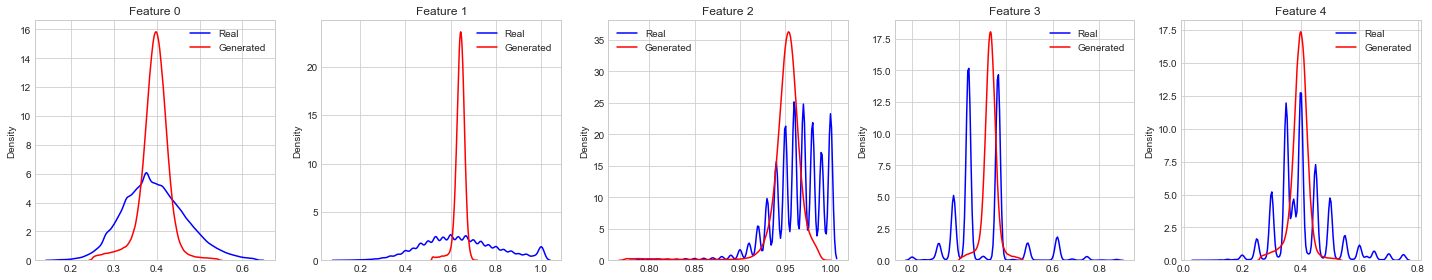

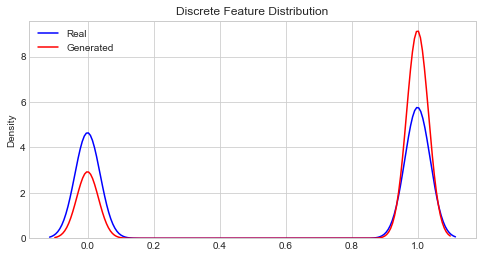

In [4]:
# Visualize distributions for continuous features
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    real_data = continuous_x[:, :, i].flatten()
    gen_data = c_gen_data[:, :, i].flatten()
    
    # Remove outliers for better visualization
    real_data = real_data[np.abs(stats.zscore(real_data)) < 3]
    gen_data = gen_data[np.abs(stats.zscore(gen_data)) < 3]
    
    sns.kdeplot(real_data, ax=axes[i], label='Real', color='blue')
    sns.kdeplot(gen_data, ax=axes[i], label='Generated', color='red')
    axes[i].set_title(f'Feature {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Visualize distributions for discrete features
plt.figure(figsize=(8, 4))
real_data = discrete_x.flatten()
gen_data = d_gen_data.flatten()
sns.kdeplot(real_data, label='Real', color='blue')
sns.kdeplot(gen_data, label='Generated', color='red')
plt.title('Discrete Feature Distribution')
plt.legend()
plt.show()

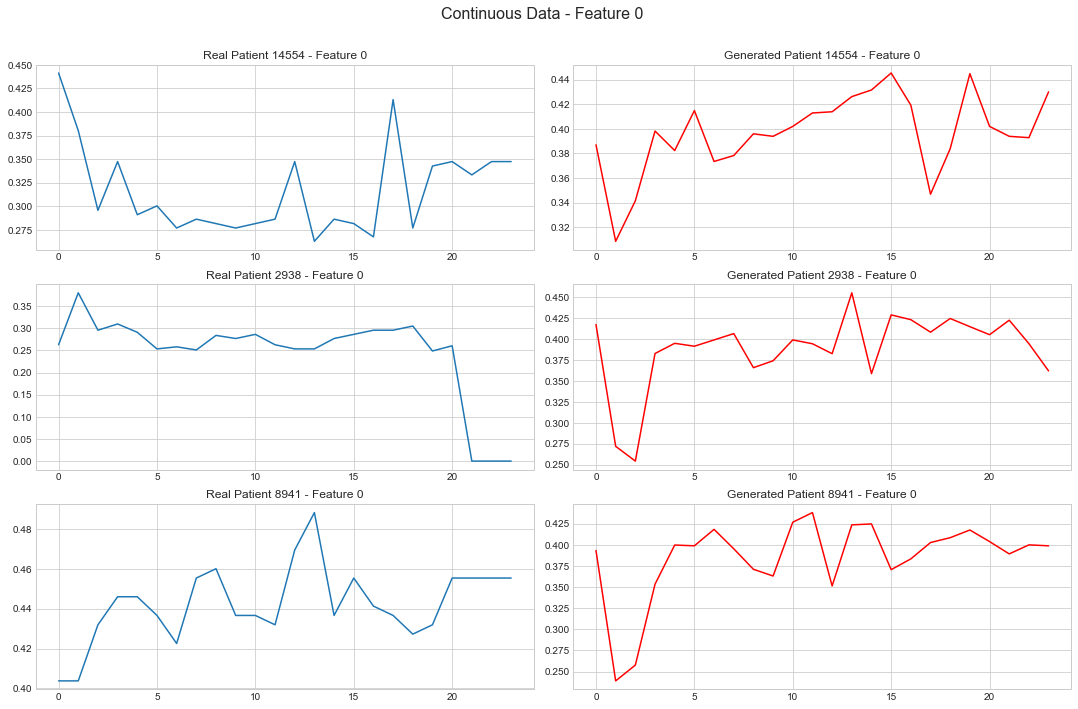

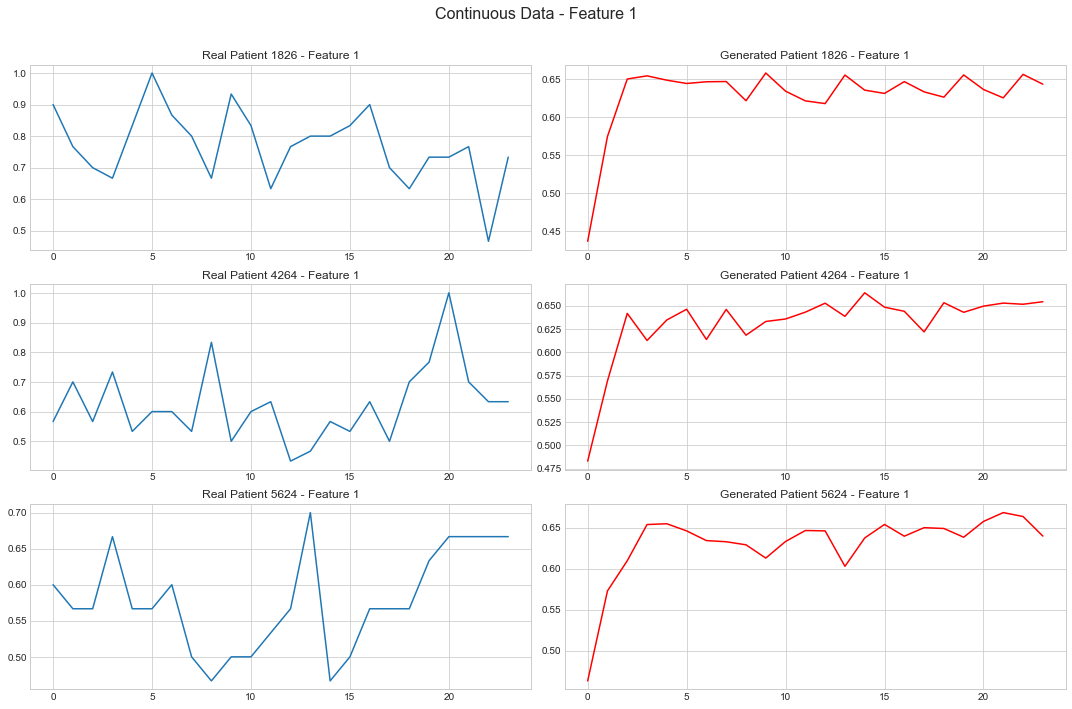

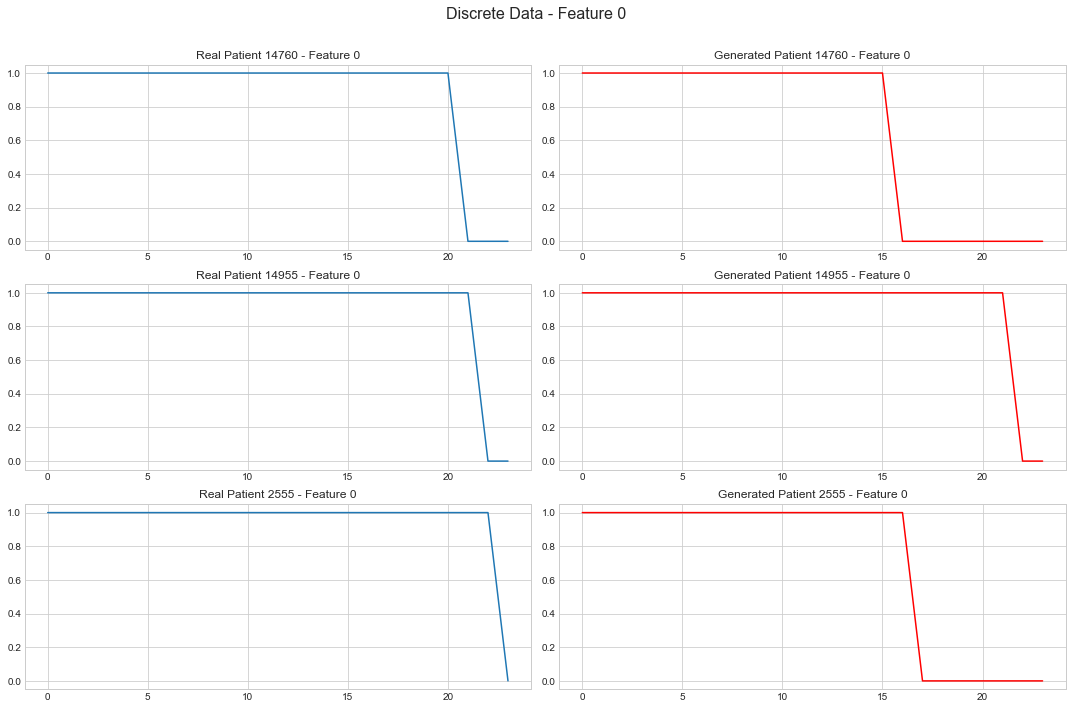

In [5]:
# Plot time series for a few random patients
def plot_time_series(real, gen, name, num_patients=3, features=None):
    if features is None:
        features = range(real.shape[2])
    
    for feature in features:
        plt.figure(figsize=(15, 10))
        for i in range(num_patients):
            # Random patient index
            idx = np.random.randint(0, len(real))
            
            plt.subplot(num_patients, 2, i*2+1)
            plt.plot(real[idx, :, feature])
            plt.title(f'Real Patient {idx} - Feature {feature}')
            
            plt.subplot(num_patients, 2, i*2+2)
            plt.plot(gen[idx, :, feature], color='red')
            plt.title(f'Generated Patient {idx} - Feature {feature}')
            
        plt.tight_layout()
        plt.suptitle(f'{name} Data - Feature {feature}', fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()

# Plot some time series
plot_time_series(continuous_x, c_gen_data, 'Continuous', num_patients=3, features=[0, 1])
plot_time_series(discrete_x, d_gen_data, 'Discrete', num_patients=3)

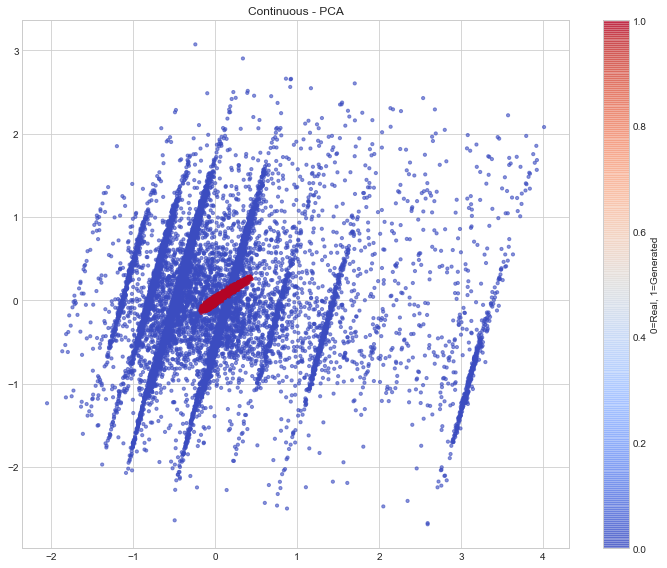

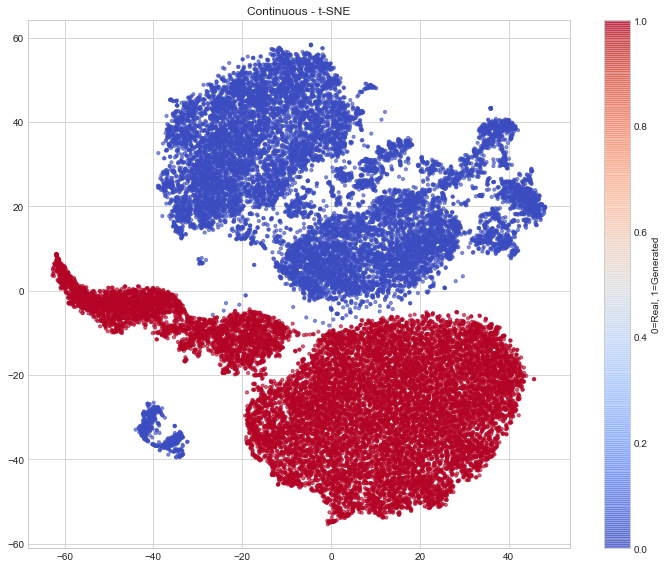

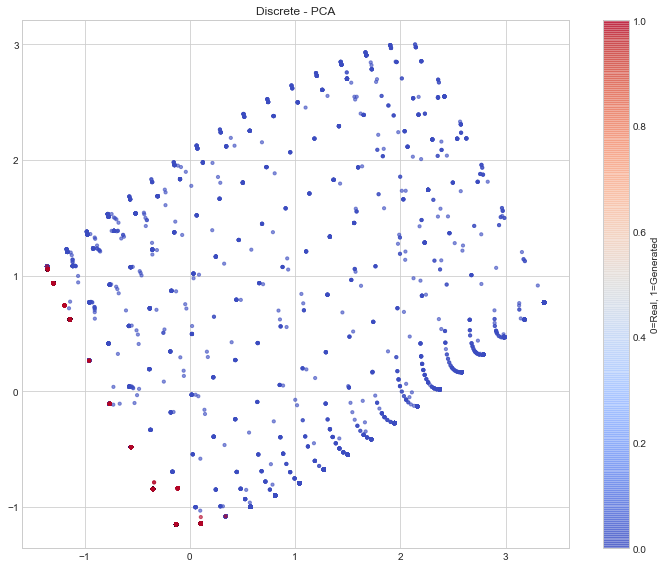

In [6]:
# Use PCA and t-SNE to visualize high-dimensional distributions
def dim_reduction_plot(real, gen, name, method='pca'):
    # Reshape to 2D: (patients, timesteps*features)
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine real and generated data
    combined = np.vstack([real_flat, gen_flat])
    
    # Labels (0 for real, 1 for generated)
    labels = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        title = f'{name} - PCA'
    else:
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        title = f'{name} - t-SNE'
    
    # Apply dimensionality reduction
    reduced = reducer.fit_transform(combined)
    
    # Visualize
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, 
               cmap='coolwarm', alpha=0.6, s=10)
    plt.colorbar(scatter, label='0=Real, 1=Generated')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# PCA and t-SNE visualization
dim_reduction_plot(continuous_x, c_gen_data, 'Continuous', method='pca')
dim_reduction_plot(continuous_x, c_gen_data, 'Continuous', method='tsne')
dim_reduction_plot(discrete_x, d_gen_data, 'Discrete', method='pca')

Train on 24576 samples, validate on 6144 samples
Epoch 1/10
24576/24576 [==============================] - 0s 14us/sample - loss: 0.3707 - acc: 0.8514 - val_loss: 0.0625 - val_acc: 0.9867
Epoch 2/10
24576/24576 [==============================] - 0s 10us/sample - loss: 0.0442 - acc: 0.9928 - val_loss: 0.0125 - val_acc: 0.9993
Epoch 3/10
24576/24576 [==============================] - 0s 10us/sample - loss: 0.0165 - acc: 0.9976 - val_loss: 0.0062 - val_acc: 0.9995
Epoch 4/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0220 - acc: 0.9941 - val_loss: 0.0063 - val_acc: 0.9995
Epoch 5/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0107 - acc: 0.9982 - val_loss: 0.0034 - val_acc: 0.9997
Epoch 6/10
24576/24576 [==============================] - 0s 10us/sample - loss: 0.0067 - acc: 0.9987 - val_loss: 0.0015 - val_acc: 0.9997
Epoch 7/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0053 - acc: 0.9989 - val_loss: 0.0016

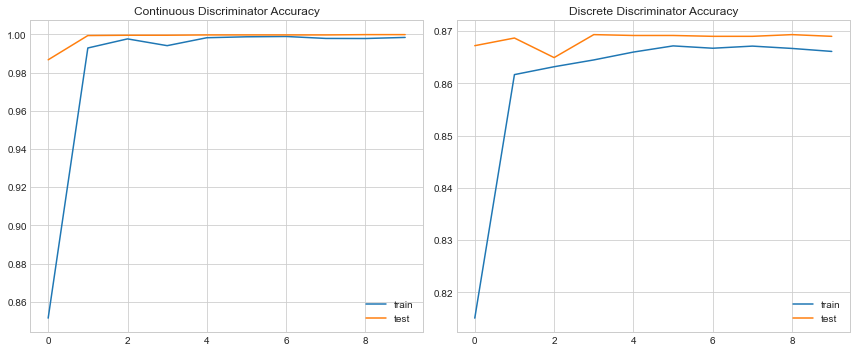

In [8]:
# Train a model to distinguish real from generated data
def train_discriminator(real, gen):
    # Prepare data
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine and create labels
    X = np.vstack([real_flat, gen_flat])
    y = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a simple neural network discriminator
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])  # Use 'acc' instead of 'accuracy' for TF 1.x
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,  # Changed to 1 to see training progress
        batch_size=128
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    apr = average_precision_score(y_test, y_pred)
    
    return auc, apr, history

# Evaluate discriminative performance
c_auc, c_apr, c_history = train_discriminator(continuous_x, c_gen_data)
print(f"Continuous data - AUC: {c_auc:.4f}, APR: {c_apr:.4f}")

d_auc, d_apr, d_history = train_discriminator(discrete_x, d_gen_data)
print(f"Discrete data - AUC: {d_auc:.4f}, APR: {d_apr:.4f}")

# Plot training history - using 'acc' instead of 'accuracy' for TF 1.x
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(c_history.history['acc'], label='train')  # Changed to 'acc'
plt.plot(c_history.history['val_acc'], label='test')  # Changed to 'val_acc'
plt.title('Continuous Discriminator Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_history.history['acc'], label='train')  # Changed to 'acc'
plt.plot(d_history.history['val_acc'], label='test')  # Changed to 'val_acc'
plt.title('Discrete Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

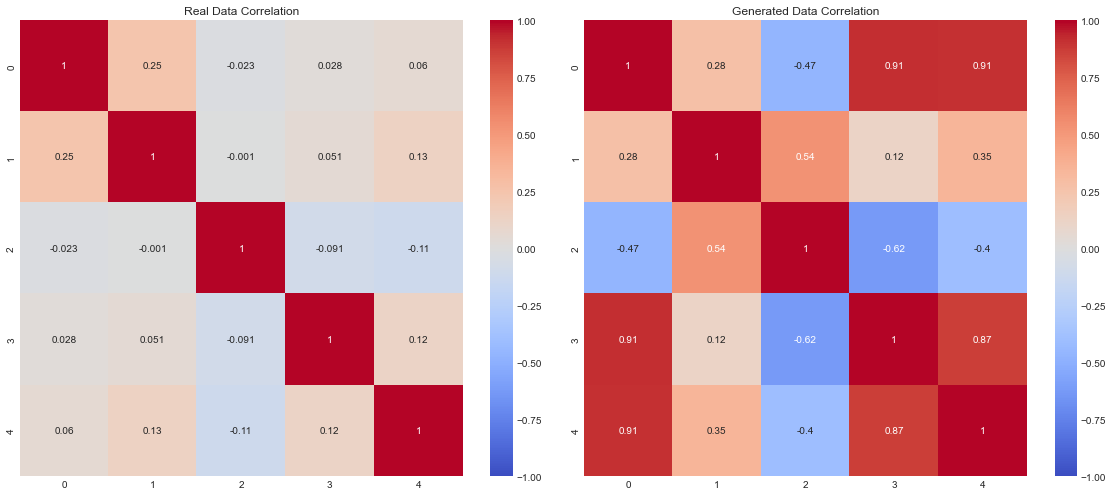

Correlation difference (L1 norm): 9.208302486497322


In [9]:
# Check correlations between vital signs (should be preserved in generated data)
def correlation_analysis(real, gen):
    # Reshape to 2D: (patients*timesteps, features)
    real_flat = real.reshape(-1, real.shape[-1])
    gen_flat = gen.reshape(-1, gen.shape[-1])
    
    # Calculate correlation matrices
    real_corr = np.corrcoef(real_flat.T)
    gen_corr = np.corrcoef(gen_flat.T)
    
    # Plot correlation matrices
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    sns.heatmap(real_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title('Real Data Correlation')
    
    sns.heatmap(gen_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title('Generated Data Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate difference in correlation matrices
    corr_diff = np.abs(real_corr - gen_corr)
    print("Correlation difference (L1 norm):", np.sum(corr_diff))
    
    return real_corr, gen_corr, corr_diff

# Only run correlation analysis on continuous data (multiple features)
if continuous_x.shape[-1] > 1:
    c_real_corr, c_gen_corr, c_corr_diff = correlation_analysis(continuous_x, c_gen_data)

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in tru

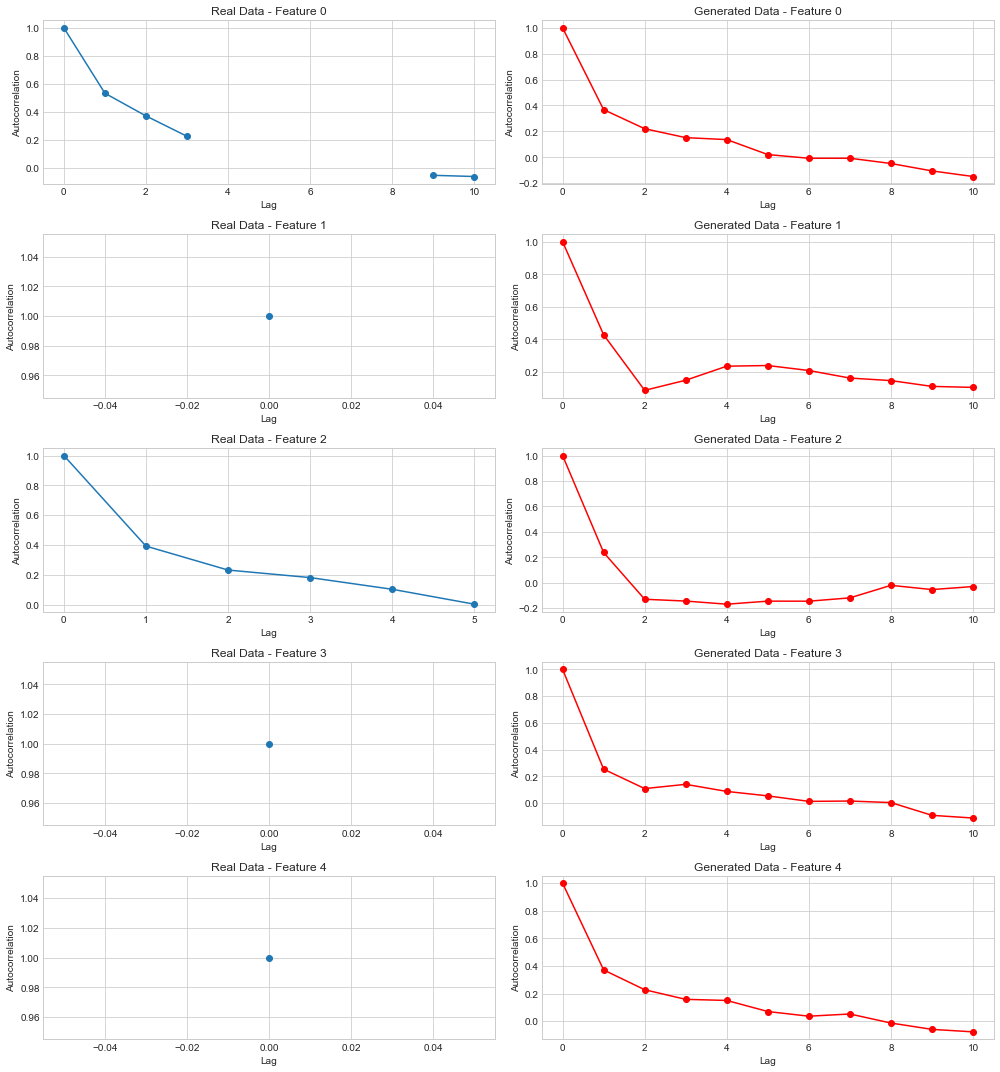

In [10]:
# Calculate autocorrelation for time series
def autocorr_analysis(real, gen, max_lag=10):
    n_features = real.shape[2]
    
    fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features))
    
    for feature in range(n_features):
        real_acorrs = []
        gen_acorrs = []
        
        # Calculate autocorrelation for each patient, then average
        for patient_idx in range(min(100, real.shape[0])):
            real_ts = real[patient_idx, :, feature]
            gen_ts = gen[patient_idx, :, feature]
            
            # Calculate autocorrelation for real data
            real_acorr = [1.0]  # Lag 0 autocorrelation is always 1
            for lag in range(1, max_lag+1):
                real_acorr.append(np.corrcoef(real_ts[lag:], real_ts[:-lag])[0, 1])
            real_acorrs.append(real_acorr)
            
            # Calculate autocorrelation for generated data
            gen_acorr = [1.0]
            for lag in range(1, max_lag+1):
                gen_acorr.append(np.corrcoef(gen_ts[lag:], gen_ts[:-lag])[0, 1])
            gen_acorrs.append(gen_acorr)
        
        # Average across patients
        real_acorr_avg = np.mean(real_acorrs, axis=0)
        gen_acorr_avg = np.mean(gen_acorrs, axis=0)
        
        # Plot
        if n_features == 1:
            ax1, ax2 = axes
        else:
            ax1, ax2 = axes[feature]
            
        ax1.plot(range(max_lag+1), real_acorr_avg, marker='o')
        ax1.set_title(f'Real Data - Feature {feature}')
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('Autocorrelation')
        
        ax2.plot(range(max_lag+1), gen_acorr_avg, marker='o', color='red')
        ax2.set_title(f'Generated Data - Feature {feature}')
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Autocorrelation')
    
    plt.tight_layout()
    plt.show()

# Calculate autocorrelation
autocorr_analysis(continuous_x, c_gen_data, max_lag=10)

In [11]:
# Create a summary table of key metrics
metrics_summary = {
    'Metric': [
        'KS Test p-value (avg)',
        'Distribution Similarity (visual)',
        'Discriminator AUC',
        'Correlation Structure',
        'Autocorrelation Structure'
    ],
    'Continuous Data': [
        np.mean([stats.ks_2samp(
            continuous_x[:, :, i].flatten(), 
            c_gen_data[:, :, i].flatten())[1] for i in range(continuous_x.shape[2])]),
        'See plots',
        c_auc,
        np.sum(np.abs(c_real_corr - c_gen_corr)) if continuous_x.shape[-1] > 1 else 'N/A',
        'See plots'
    ],
    'Discrete Data': [
        stats.ks_2samp(discrete_x.flatten(), d_gen_data.flatten())[1],
        'See plots',
        d_auc,
        'N/A',
        'See plots'
    ]
}

# Convert to DataFrame for better display
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

                             Metric Continuous Data Discrete Data
0             KS Test p-value (avg)               0             0
1  Distribution Similarity (visual)       See plots     See plots
2                 Discriminator AUC               1      0.930223
3             Correlation Structure          9.2083           N/A
4         Autocorrelation Structure       See plots     See plots


<Figure size 720x432 with 0 Axes>

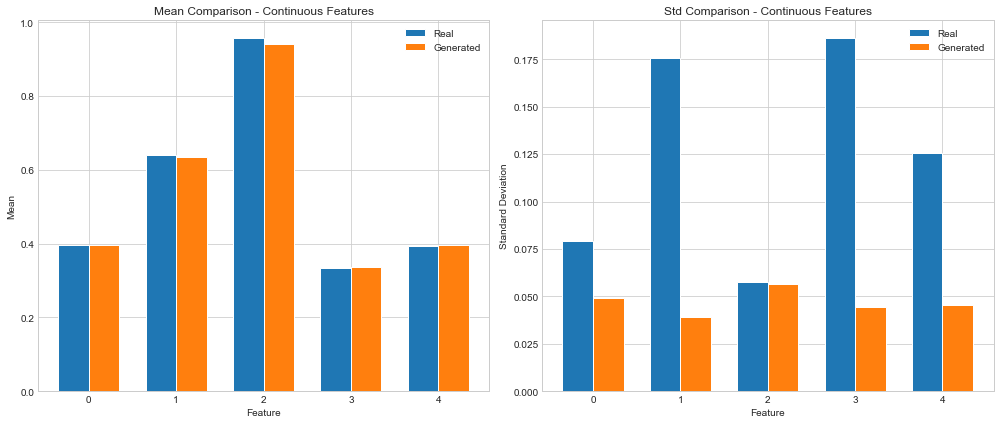

In [12]:
# Save results to CSV
metrics_df.to_csv('evaluation_results.csv', index=False)

# Save some visualization results
plt.figure(figsize=(10, 6))
# Plot mean and std comparison
features = range(continuous_x.shape[2])
x = np.arange(len(features))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mean comparison
ax1.bar(x - width/2, c_real_means, width, label='Real')
ax1.bar(x + width/2, c_gen_means, width, label='Generated')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Mean')
ax1.set_title('Mean Comparison - Continuous Features')
ax1.set_xticks(x)
ax1.legend()

# Std comparison
ax2.bar(x - width/2, c_real_stds, width, label='Real')
ax2.bar(x + width/2, c_gen_stds, width, label='Generated')
ax2.set_xlabel('Feature')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Std Comparison - Continuous Features')
ax2.set_xticks(x)
ax2.legend()

plt.tight_layout()
plt.savefig('continuous_stats_comparison.png')
plt.show()